In [1]:
!pip install -q transformers datasets librosa


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from transformers import AutoModel, AutoTokenizer
from datasets import load_dataset

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import os
import re
import random
import itertools
from collections import defaultdict
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt


**Рейтинг русских моделей** [ссылка](https://huggingface.co/spaces/mteb/leaderboard)

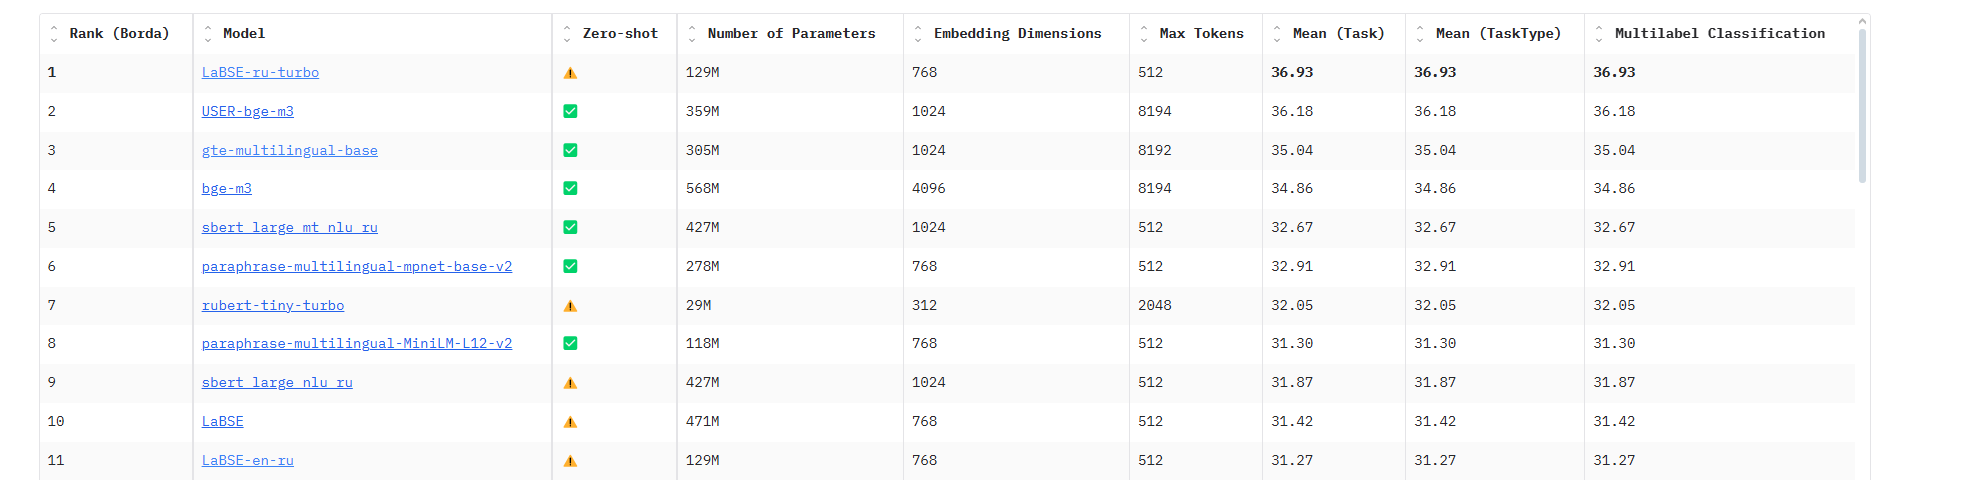

In [3]:
# выбираем одну из моделей рейтинга
BASE_MODEL=	'sergeyzh/LaBSE-ru-turbo'
EMBEDDING_DIM = 768

In [4]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

#### 🌀 Загружаем данные (предварительно загрузите их с диска в Google Colab)

[Ссылка на данные](https://disk.yandex.ru/d/awG8jCY01BGcAQ)

In [5]:
labels = ["anger", "disgust", "fear", "joy", "sadness", "surprise", "neutral"]

data = load_dataset("csv", data_files={"train": "goemo.csv", "validation": "test.csv"})
data

DatasetDict({
    train: Dataset({
        features: ['text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral'],
        num_rows: 211225
    })
    validation: Dataset({
        features: ['text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral'],
        num_rows: 1882
    })
})

#### 🔎 Выведем уникальные символы в сплитах

In [6]:
def get_alphabet(data_split):
    alphabet = set()
    for sample in data_split:
        uniq_chars = set(sample["text"])
        alphabet.update(uniq_chars)
    return alphabet

print("Train unique symbols: ", get_alphabet(data["train"]))
print("Valid unique symbols: ", get_alphabet(data["validation"]))

Train unique symbols:  {'̣', '.', '😴', '🇹', '✊', '⡆', 'T', '🚓', '⡷', '💦', '💲', 'g', 'Ж', '🎉', '🎵', '⣻', 'א', '👶', '׳', '👸', 'ﾉ', '⠴', '😘', 'ж', '😓', '\xa0', '🏻', '🧖', 'ь', '🌿', 'Ё', 'Й', '🏾', '💸', 'р', '⣧', '✨', '"', '⣷', '🇺', '͡', 'б', 'И', '🥘', '⬆', ' ', 'Щ', '🤨', 'z', '|', '😫', ';', 'Z', '🍭', '🏭', '0', '⣶', 'Y', '🤟', ',', '⠚', 'd', 'З', 'ю', 'U', 'э', '̷', '면', 'х', '̖', '🍩', '}', 'Я', '🎶', '͜', 'ё', '1', 'ᴛ', '🖖', '☁', 'ᴇ', '💗', '…', '❄', 'к', '🖤', '👇', 'Р', 'п', '⢠', '😊', '̰', 'Q', '²', '💓', 'v', 'К', '⣄', 'я', '💪', '💛', '😒', 'W', '̫', '🤰', '⛏', '⣠', '>', '⢹', '¦', '😸', 'q', '👲', 'ᴀ', 'Ю', 'B', 'с', '¯', '🤗', '🌊', '·', '中', '°', '😛', '_', 'Δ', 'Ъ', '⠿', '⢰', '😗', '⣼', '̯', 'т', '🍿', '🦗', 'y', '⠻', '!', '😰', 'О', 'Ò', 'V', '😟', 'й', '？', '😆', '̢', '̦', 'ͅ', '💁', '™', '‘', '⠄', '카', 'ɢ', '͝', '🤪', '🎏', '🧐', '☕', '≠', '查', 'Ф', 'Ɲ', '#', '⣴', 'ᴅ', '⠋', 'м', '̨', '🏊', '♡', '😹', '̹', 'r', '🙏', '̥', '허', 'ē', '💨', '😡', '*', '🤓', '⠞', 'Е', '🍌', '⭕', '😧', '👑', '2', 'H', '🍀', '(', '♀', 'b'

#### 📊 Построим гистограммы распределения

In [7]:
def plot_histogram(data_split):
    class_counts = {
        'anger': 0,
        'disgust': 0,
        'fear': 0,
        'joy': 0,
        'sadness': 0,
        'surprise': 0,
        'neutral': 0
    }

    for sample in data_split:
        for emotion in labels:
            class_counts[emotion] += sample[emotion]

    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts)
    plt.xlabel('Классы эмоций')
    plt.ylabel('Количество')
    plt.title('Распределение по классам эмоций')
    plt.xticks(rotation=45)

    plt.show()

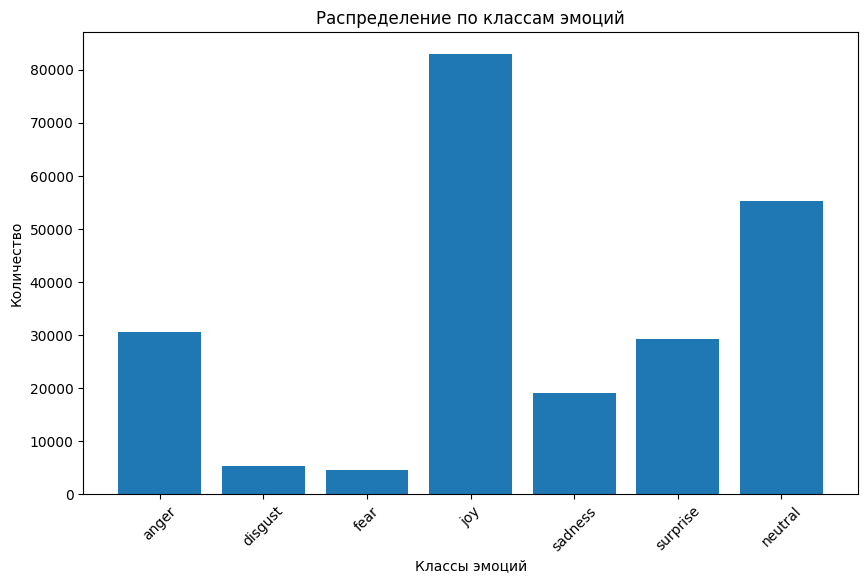

In [8]:
plot_histogram(data["train"])

In [9]:
def plot_combined_emotions(data_split):
    emotion_pairs = defaultdict(int)

    for entry in data_split:
        emotions = {key: value for key, value in entry.items() if key in labels}
        active_emotions = [emotion for emotion, value in emotions.items() if value > 0]

        for pair in itertools.combinations(sorted(active_emotions), 2):
            emotion_pairs[pair] += 1

    sorted_pairs = sorted(emotion_pairs.items(), key=lambda x: x[1], reverse=True)
    pairs = [f"{pair[0]} & {pair[1]}" for pair, _ in sorted_pairs]
    counts = [count for _, count in sorted_pairs]

    plt.figure(figsize=(12, 6))
    plt.bar(pairs, counts)
    plt.xlabel('Пары эмоций')
    plt.ylabel('Количество')
    plt.title('Совместное появление эмоций')
    plt.xticks(rotation=45)

    plt.show()

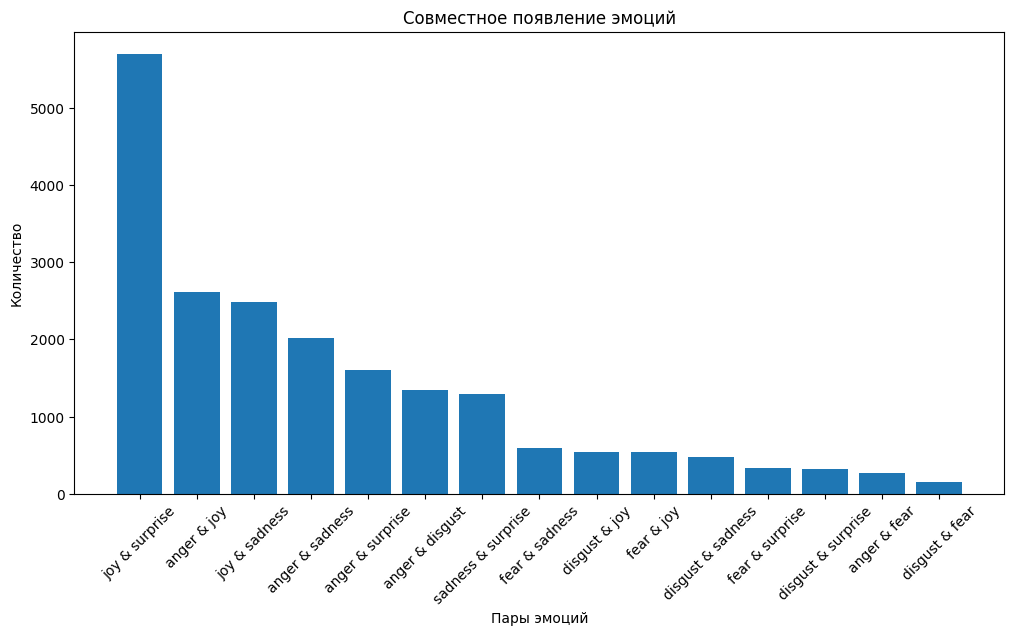

In [10]:
plot_combined_emotions(data["train"])

#### 🧹 Приведем тексты к нижнему регистру и удалим лишние знаки

In [11]:
def cleaner(example):
    example["text"] = example["text"].lower()
    example["text"] = re.sub(r"[^a-zа-я\d]", " ", example["text"])
    example["text"] = re.sub(r"\s+", " ", example["text"])
    example["text"] = example["text"].strip()
    return example

In [12]:
data = data.map(cleaner)

In [13]:
data["train"][3]

{'text': 'чувак я обожаю reddit',
 'anger': 0,
 'disgust': 0,
 'fear': 0,
 'joy': 1,
 'sadness': 0,
 'surprise': 0,
 'neutral': 0}

#### 🏋️ Подготовим модель

In [14]:
class Model(torch.nn.Module):
    def __init__(self, pretrained_model, hidden_dim, num_classes):
        super().__init__()
        self.bert = AutoModel.from_pretrained(pretrained_model)
        self.hid = torch.nn.Linear(hidden_dim, 768)
        self.drop = torch.nn.Dropout(0.85)
        self.fc = torch.nn.Linear(768, num_classes)

    def forward(self, ids, mask, token_type_ids):
        _, features = self.bert(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output = self.hid(features)
        output = self.drop(output)
        output = self.fc(output)
        return output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(pretrained_model=BASE_MODEL, hidden_dim=EMBEDDING_DIM, num_classes=len(labels))
model = model.to(device)

#### 📒 Подготовим данные для обучения

In [15]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
max_len = 64

data = data.map(lambda examples: tokenizer(examples["text"],
                                           truncation=True,
                                           add_special_tokens=True,
                                           max_length=max_len,
                                           return_token_type_ids=True,
                                           padding="max_length"), batched=True)

Map:   0%|          | 0/1882 [00:00<?, ? examples/s]

In [16]:
def one_hot_to_list(example):
    emotions = []
    for emotion in labels:
        emotions.append(example[emotion])
    example["one_hot_labels"] = emotions

    return example

data = data.map(one_hot_to_list)
data["train"][9]["one_hot_labels"]

Map:   0%|          | 0/1882 [00:00<?, ? examples/s]

[0, 0, 0, 1, 0, 0, 0]

#### 🔗 Dataset & DataLoader

In [17]:
class EmotionDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        return {
            'input_ids': torch.tensor(self.dataset[index]["input_ids"], dtype=torch.long),
            'attention_mask': torch.tensor(self.dataset[index]["attention_mask"], dtype=torch.long),
            'token_type_ids': torch.tensor(self.dataset[index]["token_type_ids"], dtype=torch.long),
            'labels': torch.tensor(self.dataset[index]["one_hot_labels"], dtype=torch.float)
        }

In [18]:
train_dataset = EmotionDataset(data["train"])
valid_dataset = EmotionDataset(data["validation"])

In [19]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

#### 🚀 Инициализируем функцию ошибки и оптимизатор

In [20]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.00001, weight_decay=0.)

#### 🥷 Код для обучения и валидации

In [21]:
def train(model, criterion, optimizer, dataloader):
    train_loss = 0.0
    model.train()
    for idx, data in enumerate(dataloader):
        ids = data["input_ids"].to(device, dtype=torch.long)
        mask = data["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = data["token_type_ids"].to(device, dtype=torch.long)
        labels = data["labels"].to(device, dtype=torch.float)

        outputs = model(ids, mask, token_type_ids)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f'Train loss: {train_loss / len(dataloader)}')

    return model

In [22]:
data['train']

Dataset({
    features: ['text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral', 'input_ids', 'token_type_ids', 'attention_mask', 'one_hot_labels'],
    num_rows: 211225
})

In [23]:
def validation(model, criterion, dataloader):
    val_loss = 0.0
    model.eval()
    val_targets, val_outputs = [], []
    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            ids = data["input_ids"].to(device, dtype=torch.long)
            mask = data["attention_mask"].to(device, dtype=torch.long)
            token_type_ids = data["token_type_ids"].to(device, dtype=torch.long)
            labels = data["labels"].to(device, dtype=torch.float)

            outputs = model(ids, mask, token_type_ids)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            val_targets.extend(labels.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    print(f'Valid loss: {val_loss / len(dataloader)}')

    return val_outputs, val_targets

#### 🏃‍♂️‍➡️ Запускаем обучение

In [24]:
epochs = 10

for epoch in range(epochs):
    print(f"Epoch: {epoch}")
    model = train(model, criterion, optimizer, train_dataloader)
    val_outputs, val_targets = validation(model, criterion, valid_dataloader)

Epoch: 0


c:\Users\rvv19\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Train loss: 0.31147339969412985
Valid loss: 0.2696967273950577
Epoch: 1
Train loss: 0.2881643517979417
Valid loss: 0.2645569294691086
Epoch: 2
Train loss: 0.2805626329392312
Valid loss: 0.2527167066931725
Epoch: 3
Train loss: 0.2742333996344682
Valid loss: 0.25477499812841414
Epoch: 4
Train loss: 0.2687409915542357
Valid loss: 0.2526921480894089
Epoch: 5
Train loss: 0.26355995823310674
Valid loss: 0.2593078091740608
Epoch: 6
Train loss: 0.25841233161354527
Valid loss: 0.2611515045166016
Epoch: 7
Train loss: 0.25371051404791073
Valid loss: 0.28117676824331284
Epoch: 8
Train loss: 0.2488832212657287
Valid loss: 0.265246574083964
Epoch: 9
Train loss: 0.2444342585566621
Valid loss: 0.27066002736488975


In [25]:
outputs_, targets = validation(model, criterion, valid_dataloader)
outputs = np.array(outputs_) >= 0.5
print(metrics.classification_report(targets, outputs, target_names=labels,digits=4))

Valid loss: 0.27066002736488975
              precision    recall  f1-score   support

       anger     0.5068    0.2960    0.3737       125
     disgust     0.0000    0.0000    0.0000         0
        fear     0.6118    0.7376    0.6688       141
         joy     0.5298    0.6799    0.5955       353
     sadness     0.7817    0.2929    0.4261       379
    surprise     0.6696    0.4529    0.5404       170
     neutral     0.8101    0.3951    0.5311       734

   micro avg     0.6547    0.4516    0.5345      1902
   macro avg     0.5585    0.4078    0.4480      1902
weighted avg     0.7052    0.4516    0.5228      1902
 samples avg     0.4450    0.4522    0.4466      1902



c:\Users\rvv19\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rvv19\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


c:\Users\rvv19\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rvv19\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rvv19\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  

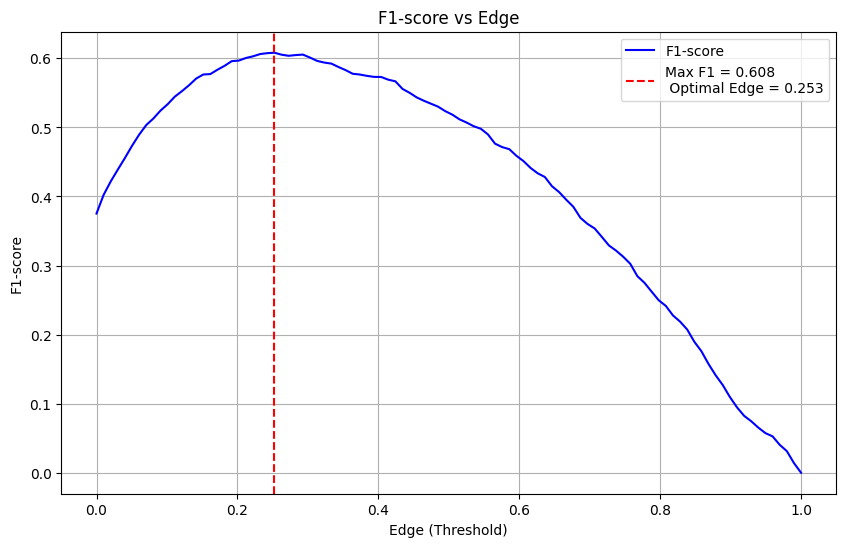

In [26]:
# проверим гипотезу что граница уверенности в классе влияет на точность 

# Диапазон значений границы
edges = np.linspace(0, 1, 100)

# Список для хранения значений F1
f1_scores = []

# Рассчитываем F1-метрику для каждого значения edge
for edge in edges:
    outputs = outputs_ >= edge
    f1 = metrics.f1_score(targets, outputs, average='weighted')
    f1_scores.append(f1)

# Находим максимальное значение F1 и соответствующий edge
max_f1 = max(f1_scores)
optimal_edge = edges[np.argmax(f1_scores)]

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(edges, f1_scores, label="F1-score", color="blue")
plt.xlabel("Edge (Threshold)")
plt.ylabel("F1-score")
plt.title("F1-score vs Edge")
plt.axvline(edges[np.argmax(f1_scores)], color='red', linestyle='--', label=f"Max F1 = {max(f1_scores):.3f} \n Optimal Edge = {optimal_edge:.3f}")
plt.legend()
plt.grid()
plt.show()

In [27]:
outputs = np.array(outputs_) >= optimal_edge
print(metrics.classification_report(targets, outputs, target_names=labels,digits=4))

              precision    recall  f1-score   support

       anger     0.2590    0.5760    0.3573       125
     disgust     0.0000    0.0000    0.0000         0
        fear     0.4516    0.8936    0.6000       141
         joy     0.3931    0.8017    0.5275       353
     sadness     0.5969    0.5040    0.5465       379
    surprise     0.4892    0.6647    0.5636       170
     neutral     0.6755    0.8025    0.7335       734

   micro avg     0.5011    0.7224    0.5917      1902
   macro avg     0.4093    0.6061    0.4755      1902
weighted avg     0.5468    0.7224    0.6082      1902
 samples avg     0.5475    0.7237    0.6045      1902



c:\Users\rvv19\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rvv19\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### ✏️ Получаем результаты на тесте

In [28]:
test = load_dataset("csv", data_files={"test": "./content/test_without_answers.csv"})

FileNotFoundError: Unable to find 'C:/work/proto_mvp/convert\./content/test_without_answers.csv'

In [ ]:
test = test.map(lambda examples: tokenizer(examples["text"],
                                           truncation=True,
                                           add_special_tokens=True,
                                           max_length=max_len,
                                           return_token_type_ids=True,
                                           padding="max_length"), batched=True)

test = test.map(one_hot_to_list)

In [ ]:
test_dataset = EmotionDataset(test["test"])
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
outputs, _ = validation(model, criterion, test_dataloader)
outputs = np.array(outputs) >= optimal_edge

Valid loss: 0.336835237049901


#### 🧑‍🍳 Готовим сабмит

In [ ]:
import pandas as pd

df = pd.read_csv("./content/test_without_answers.csv")

Изначально все метки классов инициализированы нулями, нужно их заполнить результатами модели.

In [ ]:
df.head()

,text,anger,disgust,fear,joy,sadness,surprise,neutral
0,надеюсь вы сохранили это письмо,0,0,0,0,0,0,0
1,я зашел в ваш профиль чтобы посмотреть другие ...,0,0,0,0,0,0,0
2,ты реально пустое место,0,0,0,0,0,0,0
3,я не могу сказать счастливый это конец или гру...,0,0,0,0,0,0,0
4,это 8 раундов по разным темам организованных п...,0,0,0,0,0,0,0


In [ ]:
df.insert(loc=0, column='id', value=np.arange(1, len(df) + 1))
df = df.drop(['text'],axis=1)

In [ ]:
df[labels] = outputs.astype(int)

In [ ]:
df.head()

,id,anger,disgust,fear,joy,sadness,surprise,neutral
0,1,0,0,0,1,0,0,0
1,2,0,0,0,1,0,0,0
2,3,1,0,0,0,0,0,1
3,4,0,0,0,0,1,0,0
4,5,0,0,0,0,0,0,1


In [ ]:
df.to_csv("./content/submission.csv", index=False)

In [ ]:
#сохраним модель
torch.save(model.state_dict(), 'model.pt')